In this notebook, we'll use the following techniques to train a state-of-the-art model in classifying images from the Pneumonia dataset:

- Data normalization
- Data augmentation
- Residual connections
- Batch normalization
- Learning rate scheduling
- Weight Decay
- Gradient clipping
- Adam optimizer

## Importing the required libraries

In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
from PIL import Image
import cv2
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models # Pre-Trained models
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Loading Dataset + EDA

In [7]:
from numpy import load

data = load('pneumoniamnist.npz')
lst = data.files

In [8]:
lst

['train_images',
 'val_images',
 'test_images',
 'train_labels',
 'val_labels',
 'test_labels']

In [9]:
train_X = data["train_images"] # images in numpy arrays
train_y = data["train_labels"] # numpy arrays (targets)

val_X = data["val_images"] # images in numpy arrays
val_y = data["val_labels"] # numpy arrays (targets)

In [10]:
print(f'Train Size = {len(train_X)}')
print(f'Public Test Size = {len(val_X)}')

Train Size = 4708
Public Test Size = 524


## Data Preprocessing

In [11]:
# Data transforms (normalization & data augmentation)
# stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

train_tfms = tt.Compose([tt.Resize(128),
                        tt.CenterCrop(128),
                        # tt.RandomRotation(5),
                        tt.RandomGrayscale(),
                        tt.RandomAffine(translate=(0.03,0.03), degrees=0),
                        tt.ToTensor(),
                        # tt.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
])

valid_tfms = tt.Compose([tt.Resize(128), # no_aug
                         tt.CenterCrop(128),
                         tt.ToTensor(),
                        #  tt.Normalize(mean=[0.485, 0.456, 0.406],std= [0.229, 0.224, 0.225])
])

In [12]:
# Our own custom class for datasets

from torch.utils.data import Dataset

class CreateDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [13]:
train_X[0].shape

(28, 28)

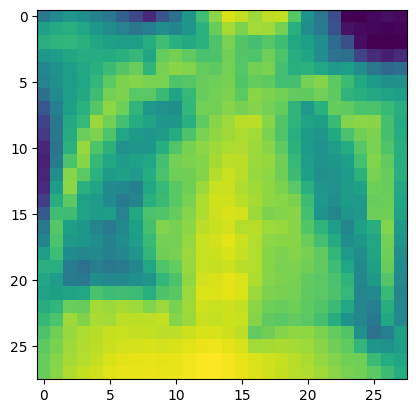

In [14]:
from matplotlib import pyplot as plt
plt.imshow(train_X[0], interpolation='nearest')
plt.show()

In [15]:
Image.fromarray(train_X[0].astype(np.uint8))

In [16]:
train_data = CreateDataset(data=train_X, targets=train_y, transform=train_tfms)
val_data = CreateDataset(data=val_X, targets=val_y, transform=valid_tfms)

In [17]:
# # Percentage of training set to use as validation
# valid_size = 0.15

# # obtain training indices that will be used for validation
# num_train = len(train_data)
# indices = list(range(num_train))
# split = int(np.floor(valid_size * num_train))
# train_idx, valid_idx = indices[split:], indices[:split]

# # Create Samplers
# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

In [18]:
batch_size = 32
num_workers = 8

In [19]:
# PyTorch data loaders
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
valid_dl = DataLoader(val_data, batch_size, num_workers=num_workers, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
len(train_dl)

148

In [21]:
len(valid_dl)

17

## Visualizing Training Data

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


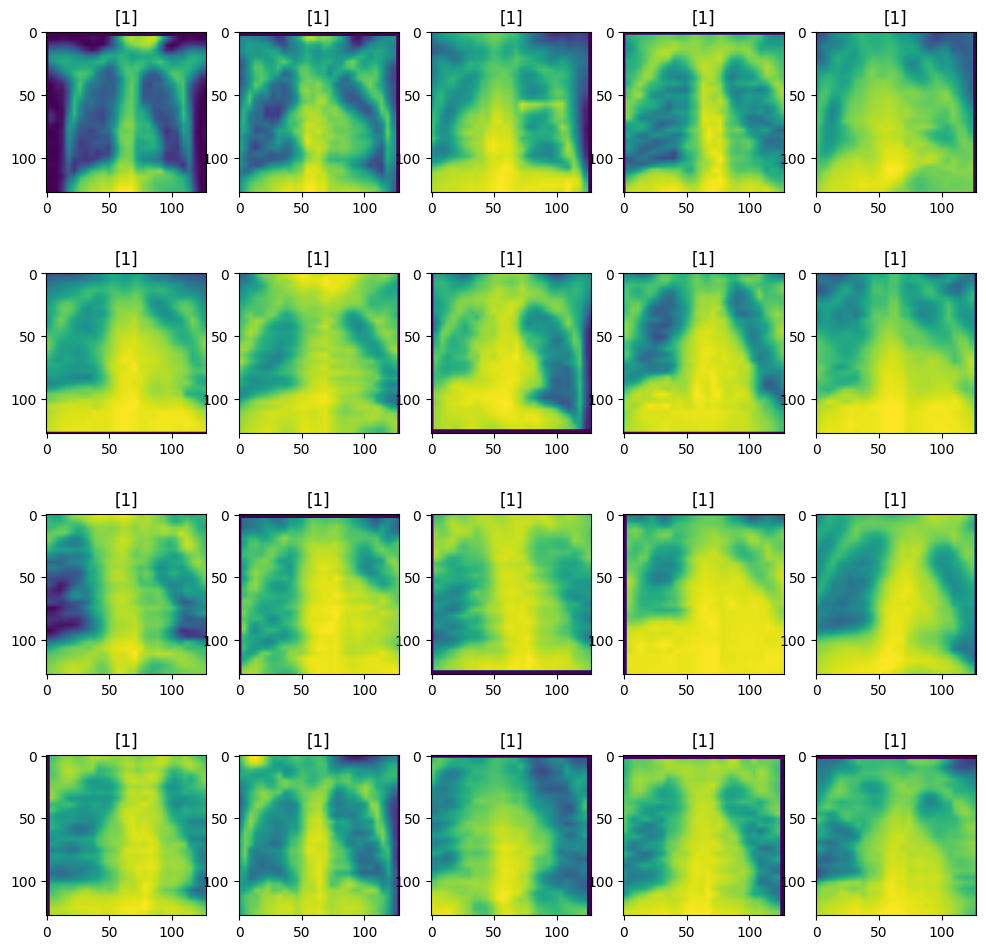

In [22]:
_, axs = plt.subplots(4, 5, figsize=(12, 12))
axs = axs.flatten()

for x in train_dl:
    break

for img, ax, label in zip(x[0][:20], axs, x[1][:20]):
    ax.set_title(train_y[label.item()])
    ax.imshow(img.permute(1, 2, 0).numpy())
plt.show()

## Define Model Architecture

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [24]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU.

In [25]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [26]:
torch.cuda.empty_cache()

In [27]:
def accuracy(outputs, labels):
    outputs = torch.from_numpy(outputs)
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == torch.tensor(labels).squeeze()).item() / len(preds))

In [28]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        # print(images.shape)
        # print(labels.shape)
        out = self(images)                  # Generate predictions
        loss = nn.SmoothL1Loss()(out, labels.float()) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = nn.SmoothL1Loss()(out, labels.float())   # Calculate loss
        out = out.cpu().numpy()
        labels = labels.cpu().numpy()
        acc = accuracy(out.round(), labels)           # Calculate score
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        batch_accs = torch.Tensor(batch_accs)
        epoch_accs = torch.stack(tuple(batch_accs)).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_accs.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [29]:
class PneumoniaDetectorModel(ImageClassificationBase):
    def __init__(self, pretrained=False):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet152(pretrained=pretrained)

        # Modify the first convolutional layer to accept 1 channel input
        self.network.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Replace last layer
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, 1)

    def forward(self, xb):
        return self.network(xb)

In [30]:
model = to_device(PneumoniaDetectorModel(), device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


PneumoniaDetectorModel(
  (network): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequent

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [32]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 17327770.0, 'val_acc': 0.2542892396450043}]

In [33]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [34]:
history

[{'val_loss': 17327770.0, 'val_acc': 0.2542892396450043}]

In [35]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 0.1413, val_loss: 0.0630, val_acc: 0.2543
Epoch [1], last_lr: 0.00935, train_loss: 0.0690, val_loss: 0.0364, val_acc: 0.2543
Epoch [2], last_lr: 0.00972, train_loss: 0.0454, val_loss: 0.1108, val_acc: 0.2543
Epoch [3], last_lr: 0.00812, train_loss: 0.0291, val_loss: 0.0399, val_acc: 0.2543
Epoch [4], last_lr: 0.00556, train_loss: 0.0217, val_loss: 0.0817, val_acc: 0.2543
Epoch [5], last_lr: 0.00283, train_loss: 0.0194, val_loss: 0.0220, val_acc: 0.2543
Epoch [6], last_lr: 0.00077, train_loss: 0.0137, val_loss: 0.0104, val_acc: 0.2543
Epoch [7], last_lr: 0.00000, train_loss: 0.0100, val_loss: 0.0100, val_acc: 0.2543
CPU times: user 3min 24s, sys: 1min 39s, total: 5min 4s
Wall time: 5min 43s


In [36]:
def plot_accuracy(history):
    accs = [x['val_acc'] for x in history]
    plt.plot(accs, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy_score')
    plt.title('Accuracy vs. No. of epochs');

In [37]:
history

[{'val_loss': 0.06301259994506836,
  'val_acc': 0.2542892396450043,
  'train_loss': 0.14128080010414124,
  'lrs': [0.0003999999999999993,
   0.00040018880392837797,
   0.0004007552008606259,
   0.0004016991462392587,
   0.0004030205658056944,
   0.0004047193556060997,
   0.0004067953819995619,
   0.0004092484816686035,
   0.00041207846163203964,
   0.00041528509926014485,
   0.0004188681422921791,
   0.00042282730885622247,
   0.00042716228749136234,
   0.0004318727371721825,
   0.000436958287335594,
   0.0004424185379099995,
   0.0004482530593467454,
   0.0004544613926539282,
   0.00046104304943250275,
   0.00046799751191469244,
   0.0004753242330047345,
   0.0004830226363219097,
   0.0004910921162458899,
   0.0004995320379643786,
   0.000508341737523052,
   0.0005175205218777932,
   0.0005270676689492094,
   0.0005369824276794354,
   0.0005472640180912234,
   0.0005579116313493004,
   0.0005689244298239908,
   0.0005803015471571235,
   0.0005920420883301809,
   0.0006041451297347077,

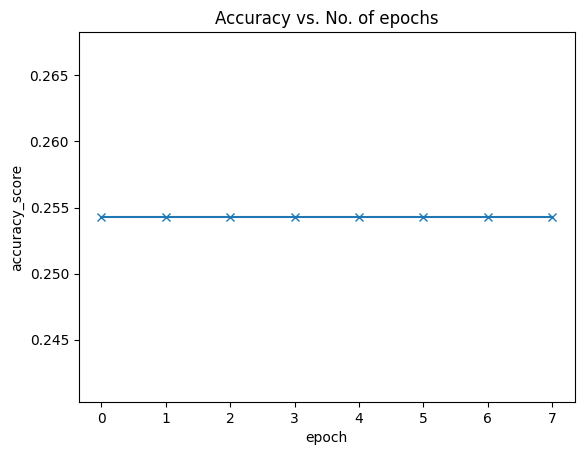

In [38]:
plot_accuracy(history)

We can also plot the training and validation losses to study the trend.

In [39]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

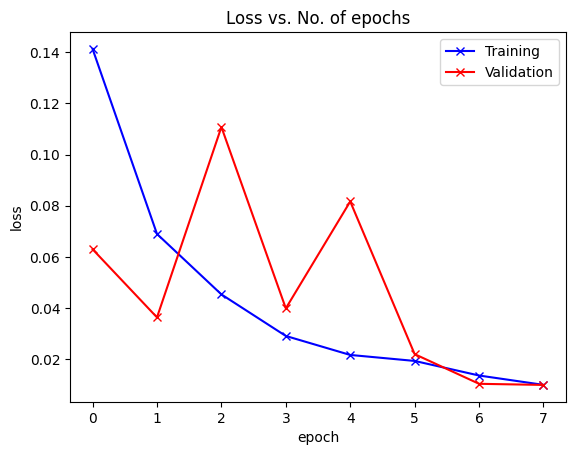

In [40]:
plot_losses(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images.



In [41]:
torch.save(model.state_dict(), 'pneumonia-detector-resnet152-1-feature-output.pth')

In [50]:
 def round_off_preds(preds, coef=0.5):
    for i, pred in enumerate(preds):
        if pred < coef:
            preds[i] = 0
        else:
            preds[i] = 1
    return preds

In [51]:
def predict_single_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    preds = int(round_off_preds(yb))
    # Retrieve the class label
    # return class_list[preds]
    return preds

[1]


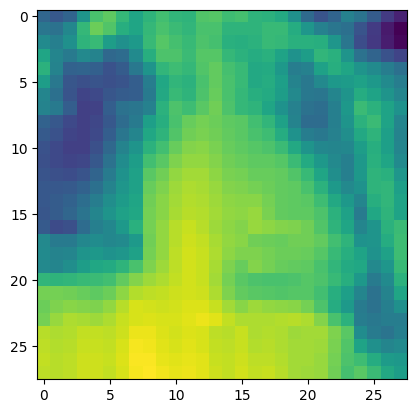

In [52]:
from matplotlib import pyplot as plt
print(val_y[0])
plt.imshow(val_X[0], interpolation='nearest')
plt.show()

In [53]:
for i in valid_dl:
  break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Predicted: 1


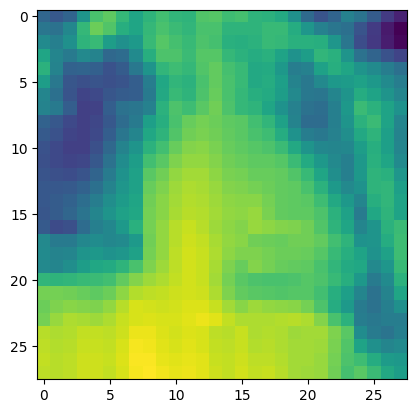

In [54]:
plt.imshow(val_X[0]) # .permute(1, 2, 0).clamp(0, 1)
print('Predicted:', predict_single_image(i[0][0], model))

In [55]:
def predict(testloader):
    '''Function used to make predictions on the test set'''
    model.eval()
    preds = []
    for batch_i, (data, target) in enumerate(testloader):
        data, target = data.cuda(), target.cuda()
        output = model(data)
        pr = output.detach().cpu().numpy()
        # print(pr)
        for i in pr:
            preds.append(i.tolist())

    return preds

In [56]:
# test_dl = DataLoader(test_data, batch_size)

In [57]:
preds = np.array(predict(testloader=valid_dl))

In [58]:
preds

array([[ 9.99196172e-01],
       [ 9.46271300e-01],
       [ 9.77118492e-01],
       [-4.22112122e-02],
       [ 1.00817227e+00],
       [ 9.77777123e-01],
       [ 7.54915297e-01],
       [-1.46615580e-02],
       [ 9.83975470e-01],
       [ 6.03187561e-01],
       [ 9.92541492e-01],
       [-1.43560693e-02],
       [ 1.00703883e+00],
       [ 9.82958674e-01],
       [ 1.29830763e-02],
       [ 1.00283837e+00],
       [ 9.24599051e-01],
       [ 9.94667053e-01],
       [ 9.67482448e-01],
       [ 9.76062953e-01],
       [ 9.73894119e-01],
       [ 9.82740819e-01],
       [-2.03490779e-02],
       [ 9.66313958e-01],
       [ 9.47471738e-01],
       [ 9.98549223e-01],
       [ 9.92926717e-01],
       [ 9.96356487e-01],
       [-8.52113888e-02],
       [ 9.98504400e-01],
       [ 1.31460994e-01],
       [-1.76767334e-02],
       [ 9.99682426e-01],
       [-2.71393359e-03],
       [ 9.86146271e-01],
       [-2.11621225e-02],
       [ 9.96287823e-01],
       [-1.80870518e-02],
       [-5.3

In [59]:
preds = round_off_preds(preds)

In [60]:
preds

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],